In [219]:
# Question Characteristics: 
# Tags, Length of Post, Network Characteristics of user, (to come: Language used)
# Outcome: Time till First Answer, Time till first (good) Answer
# (One week from today, how many answers expected to receive? how many good answers expected to receive?)

In [220]:
import dill
import os
import random
import pandas as pd
from pandas import Series
from sklearn import base, model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

os.chdir('/home/vagrant/projects/stackoverflow-post')
df_tag = dill.load(open('data/df_tag.pkd', 'r'))
centrality = dill.load(open('centrality.pkd', 'r'))
top10tags = dill.load(open('data/top10tags.pkd', 'r'))
# body_len_est = dill.load(open('body_len_est.pkd', 'r'))
# tag_rf_est = dill.load(open('tag_rf_est.pkd', 'r'))
# network_est = dill.load(open('network_est.pkd', 'r'))

In [221]:
dataset = df_tag[np.isfinite(df_tag['fa_time'])]
dataset['top10'] = dataset[top10tags].sum(axis=1)
dataset = dataset.loc[dataset.top10 == 1] #only focus on tags in top 10
dataset = dataset.drop(['top10'], axis = 1)

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [222]:
data = dataset.join(centrality, on = 'q_owner') #join network matrix
X = data.loc[:, data.columns != 'fa_time']
y = data.fa_time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [223]:
data.head()

,fa_score,fa_time,q_body,q_body_len,q_date,q_owner,q_score,q_tag,q_title,s10_time,...,out degree,degree centrality,in degree centrality,out degree centrality,allN,outN,inN,avg_n_contact,avg_n_in_contact,avg_n_out_contact
0,4.0,434.554,<p>I am thinking along the lines of replicatin...,367,2008-09-19 05:09:25.977,essexboyracer,0,<php>,Convert/extract phpinfo() into php.ini,NaN,...,4,0.000027,0.0,0.000027,4,4,0,1.0,NaN,1.0
1,2.0,11504.657,<p>Has anyone any reources for learning how to...,402,2008-09-24 06:42:46.107,essexboyracer,2,<php><mysql><svg><vector-graphics><php-gtk>,Interactive SVG - Learning Resources?,NaN,...,4,0.000027,0.0,0.000027,4,4,0,1.0,NaN,1.0
2,1.0,1630433.760,<p>I'm trying to decode a WBXML encoded SyncML...,632,2008-10-22 15:25:00.777,11542,1,<python><s60><syncml><wbxml>,Decoding a WBXML SyncML message from an S60 de...,NaN,...,24,0.000164,0.0,0.000164,24,24,0,1.0,NaN,1.0
5,6.0,54503.460,<p>How can UTF-8 strings (i.e. 8-bit string) b...,975,2008-09-22 23:55:02.883,11543,0,<php><html><xml><unicode><utf-8>,Convert a UTF-8 string to/from 7-bit XML in PHP,NaN,...,0,0.000000,0.0,0.000000,0,0,0,NaN,NaN,NaN
6,20.0,455.910,<p>JavaScript allows functions to be treated a...,749,2008-09-23 22:30:54.573,11543,0,<javascript><function><properties>,"How to convert an ""object"" into a function in ...",455.91,...,0,0.000000,0.0,0.000000,0,0,0,NaN,NaN,NaN


In [224]:
bodynames = ['q_body_len'] #post language characteristics
tagnames = list(X_train.columns.values[12:50]) #tags of post
nxnames = list(X_train.columns.values[50:]) #network centrality of user (who posted questions)

In [225]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.col_names]

class FillNetworkNATransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(0)
    
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    def transform(self, X):
        return np.array([self.estimator.predict(X)]).T
# class EnsembleTransformer(base.BaseEstimator, base.TransformerMixin):
#     def __init__(self, base_estimator, residual_estimator):
#         self.base_estimator = base_estimator
#         self.residual_estimator = residual_estimator
#     def fit(self, X, y):
#         self.base_estimator.fit(X, y)
#         y_err = y-self.base_estimator.predict(X)
#         self.residual_estimator.fit(X, y_err)
#         return self
#     def transform(self, X):
#         all_ests = [self.base_estimator] + [self.residual_estimator]
#         return np.array([est.predict(X) for est in all_ests]).T
# scaler = StandardScaler()

In [226]:
# use Random Forest Estimator
md_range = np.arange(2,22,2) #search max_depth = 2:20
msl_range = np.arange(20,35,5) #search min_sanokes_leaf = 20,25,30,35
ne_range = np.arange(10,40,5) #search n_estimators = 10,15,20,25,30,35
est = RandomForestRegressor()
rf = model_selection.GridSearchCV(
    est, 
    {'max_depth': md_range,
    'min_samples_leaf': msl_range,
    'n_estimators': ne_range},
    cv = 10,
    n_jobs = 2,
    scoring = 'neg_mean_squared_error'
)

In [227]:
#1. question body length
cst = ColumnSelectTransformer(bodynames)
x_train = cst.fit_transform(X_train)
rf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([10, 15, 20, 25, 30, 35]), 'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), 'min_samples_leaf': array([20, 25, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [228]:
rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=30,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [229]:
body_len_est = Pipeline([
    ('csv', ColumnSelectTransformer(bodynames)),
    ('en', rf.best_estimator_)
])
body_len_est.fit(X_train, y_train)
dill.dump(body_len_est, open('body_len_est.pkd', 'w'))

In [230]:
# Tags
cst = ColumnSelectTransformer(tagnames)
x_train = cst.transform(X_train)
rf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([10, 15, 20, 25, 30, 35]), 'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), 'min_samples_leaf': array([20, 25, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [231]:
rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=30,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [232]:
tag_rf_est = Pipeline([
    ('csv', ColumnSelectTransformer(tagnames)),
    ('en', rf.best_estimator_)
])
tag_rf_est.fit(X_train, y_train)
dill.dump(tag_rf_est, open('tag_rf_est.pkd', 'w'))

In [233]:
#3 network centrality
cst = ColumnSelectTransformer(nxnames)
fna = FillNetworkNATransformer()
x_train = cst.transform(X_train)
x_train = fna.transform(x_train)
rf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([10, 15, 20, 25, 30, 35]), 'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), 'min_samples_leaf': array([20, 25, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [234]:
rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=30,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [235]:
network_est = Pipeline([
    ('csv', ColumnSelectTransformer(nxnames)),
    ('fna', FillNetworkNATransformer()),
    ('en', rf.best_estimator_)
])

In [236]:
network_est.fit(X_train, y_train)
dill.dump(network_est, open('network_est.pkd', 'w'))

In [237]:
body_len_trans = EstimatorTransformer(body_len_est)
tag_rf_trans = EstimatorTransformer(tag_rf_est)
network_trans = EstimatorTransformer(network_est)

In [238]:
union = FeatureUnion([
    ('body_len', body_len_trans),
    ('tag_rf', tag_rf_trans),
    ('network', network_trans)
])

In [239]:
# union.fit(X)
union.fit(X_train, y_train)

FeatureUnion(n_jobs=1,
       transformer_list=[('body_len', EstimatorTransformer(estimator=Pipeline(steps=[('csv', ColumnSelectTransformer(col_names=['q_body_len'])), ('en', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-0...tors=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])))],
       transformer_weights=None)

In [240]:
full_est = Pipeline([
    ('union', union),
    ('blend', RandomForestRegressor(min_samples_leaf = 20))
])
full_est.fit(X_train, y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('body_len', EstimatorTransformer(estimator=Pipeline(steps=[('csv', ColumnSelectTransformer(col_names=['q_body_len'])), ('en', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [241]:
pred = full_est.predict(X_test)

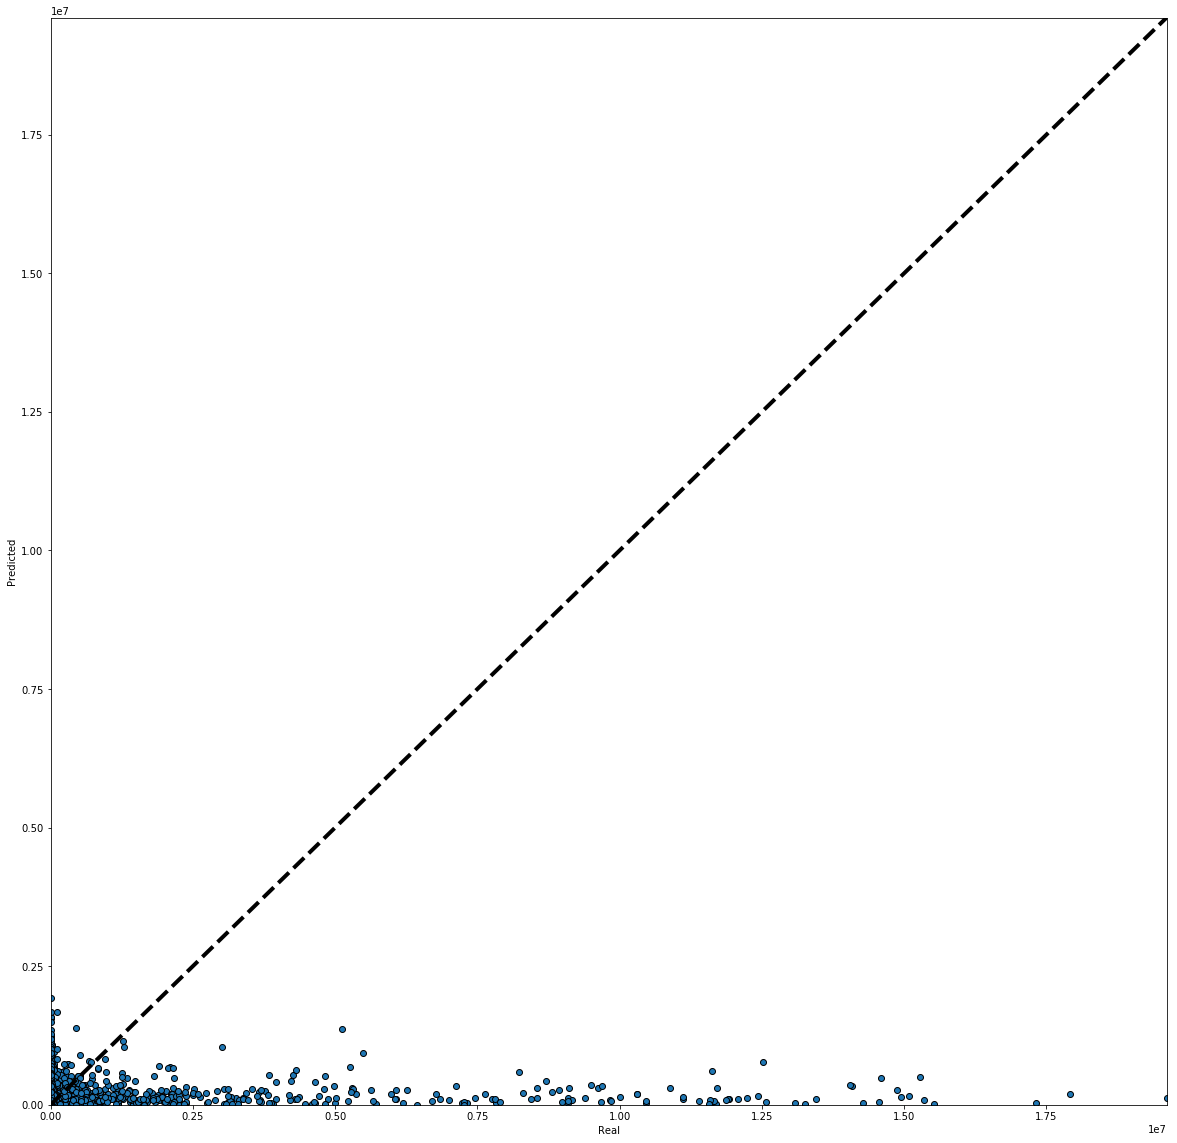

In [245]:
# plt.plot(pred, 'bo', y_test, 'ro', markersize=5)
# plt.show()
thrh = y_test.max()
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(y_test, pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), thrh], [y_test.min(), thrh], 'k--', lw=4)
ax.set_xlim([y_test.min(), thrh])
ax.set_ylim([y_test.min(), thrh])
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()